# Picking the gamma (length scale) value for Regression with RBF kernel

Here we use the quantile heuristics same as [SVM_rbf_gamma notebook](https://github.com/chengsoonong/didbits/blob/master/Estimation/SVM_rbf_gamma.ipynb). 

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np

import pandas
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels_pairwise import spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF
from sklearn.kernel_ridge import KernelRidge

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Reading the Dataset

In [3]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

Path = '../data/trainset.rbs1.v2.csv'

df = pandas.read_csv(Path, delimiter=',')
df.head()

,Construct,Barcode,rbs1_1_A,rbs1_1_C,rbs1_1_G,rbs1_1_T,rbs1_2_A,rbs1_2_C,rbs1_2_G,rbs1_2_T,...,rbs2_3_A,rbs2_3_C,rbs2_3_G,rbs2_3_T,Group,ODind,ODhar,FC,rbs1,rbs2
0,RBS629,77DD32,0,0,1,0,0,0,1,0,...,0,0,1,0,Top,0.410,4.523,1.437982,GGG,GGG
1,RBS678,77DD39,0,0,1,0,0,0,1,0,...,0,0,1,0,Top,0.359,2.678,1.277175,GGG,GGG
2,RBS353,77DD18,0,0,1,0,0,0,1,0,...,0,0,1,0,Top,0.334,1.745,1.545141,GGC,GGG
3,RBS403,77DD20,0,0,1,0,0,0,1,0,...,1,0,0,0,Top,0.390,2.166,1.670098,GGC,GGA
4,RBS500,77DD24,0,0,1,0,0,0,1,0,...,0,1,0,0,Top,0.375,2.348,1.621230,GGC,GGC


In [4]:
Log_flag = False # indicates whether take log label
Norm_method = 'minmax' # indicates how to normalize label (one of 'mean', 'minmax', None)

In [5]:
data = np.asarray(df.iloc[:, 2:26])
data.shape

(60, 24)

## Picking a good gamma value

The ``gamma`` parameter appears as follows.
Using a rbf kernel, we measure similarity between datapoints by $k(x, y) = \exp(-\gamma||x-y||^2)$.
If $\gamma||x-y||^2$ is very small -- i.e., if $\frac{1}{\gamma}$ is much larger than $||x-y||^2$ -- $k(x, y)$ will be close to 1.
So a small $\gamma$ value, relative to the distances between datapoints, means the influence of a single datapoint reaches over most of the dataset.
If $\gamma||x-y||^2$ is very large, then $k(x, y)$ will be close to 0.
That is, for a large $\gamma$ value, a given datapoint has influence only on datapoints very close to it.

To pick a good ``gamma`` value, we would use cross validation. To do cross validation, we need to know what range sensible ``gamma`` values lie in.
To find this range, we use a heuristic.
We want the influence of each datapoint to extend over some but not all of the dataset -- that is, we want ``gamma`` to be some value such that $\gamma||x-y||^2$ is neither very large nor very small.

We thus want $\frac{1}{\gamma}$ to be of similar magnitude to "typical" values of $||x-y||^2$.

In [6]:
pairs = itertools.combinations(data, r = 2)
distances = [np.linalg.norm(a-b)**2 for a,b in pairs]
distances.sort()
gamma_values = [distances[int(len(distances)*frac)] for frac in [0.1, 0.3, 0.5, 0.7, 0.9]]
print(gamma_values)

[4.0, 5.999999999999999, 5.999999999999999, 8.000000000000002, 10.000000000000002]


In [7]:
# PS. in sklearn gpr.kernel RBF using length scales instead

len_scale = np.sqrt(0.5 * np.asarray(gamma_values))
len_scale = list(set(len_scale))
len_scale

[1.4142135623730951, 2.0, 2.23606797749979, 1.7320508075688772]

We also compare with length scale of 0.1, 1, 10 and 100, to show values outside this range.

In [8]:
len_scale.extend([0.1, 1, 10, 100])
len_scale

[1.4142135623730951,
 2.0,
 2.23606797749979,
 1.7320508075688772,
 0.1,
 1,
 10,
 100]

## Regression

In [9]:
df['RBS'] = df['rbs1'] + df['rbs2']

# take log FC -- possiblely provide Gaussain distribution?
if Log_flag:
    df['FC'] = np.log(df['FC'])

if Norm_method == 'mean':
    # mean normalization
    df['FC'] = (df['FC'] - df['FC'].mean())/df['FC'].std()
elif Norm_method == 'minmax':
    # min-max normalization 
    df['FC'] = (df['FC'] - df['FC'].min())/(df['FC'].max() - df['FC'].min())
else:
    assert Norm_method == None

data = np.asarray(df[['RBS', 'FC']])
data.shape

(60, 2)

In [10]:
# indicates whether cross validation (KFOLD)
cross_val_flag = False 

# indicates whether plot predict_label vs. true label
plot_flag = True 

# name dictionaries
regression_name = {KernelRidge: 'KR',
                  GaussianProcessRegressor: 'GPR'}


train_scores = {}
test_scores = {}

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=RBF(length_scale=1.41), kernel_params=None)
Train RMSE:  0.14652065853695895
Test RMSE:  0.17950344552526645

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel=RBF(length_scale=2),
            kernel_params=None)
Train RMSE:  0.15827913933888
Test RMSE:  0.16408655290967109

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=RBF(length_scale=2.24), kernel_params=None)
Train RMSE:  0.16311062761283782
Test RMSE:  0.1636243252125276

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=RBF(length_scale=1.73), kernel_params=None)
Train RMSE:  0.15244633861784826
Test RMSE:  0.1673875465480979

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=RBF(length_scale=0.1), kernel_params=None)
Train RMSE:  0.26881829052711637
Test RMSE:  0.44680193740967455

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kern

/home/mengyan/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([6380.0039463]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


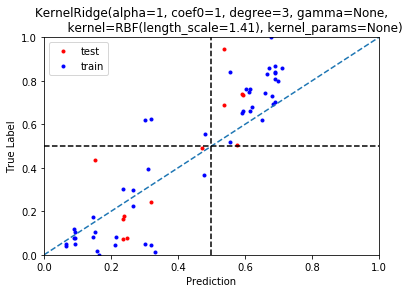

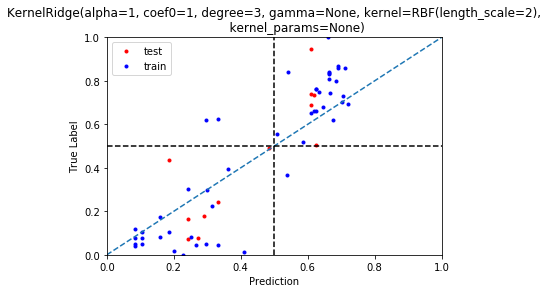

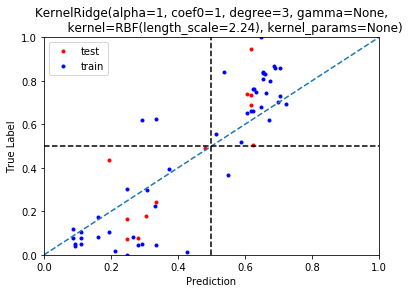

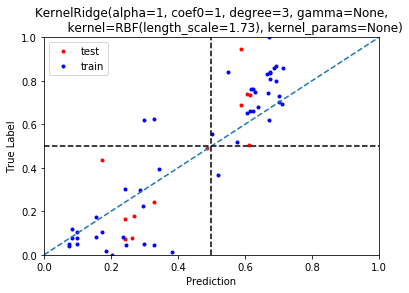

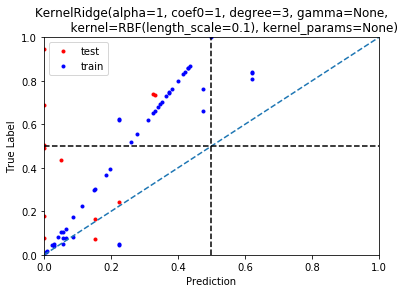

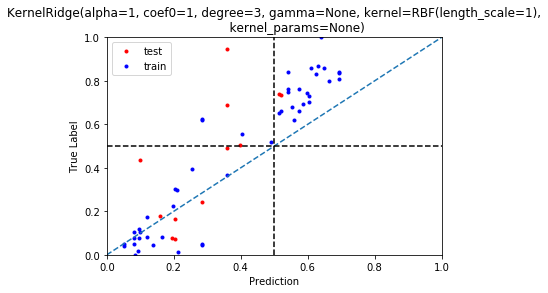

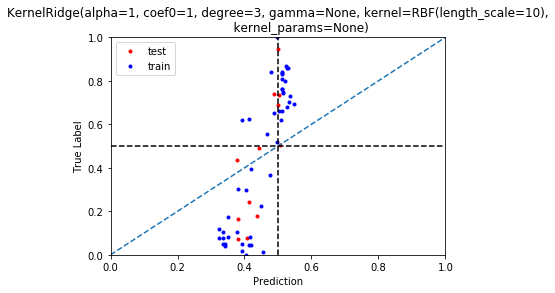

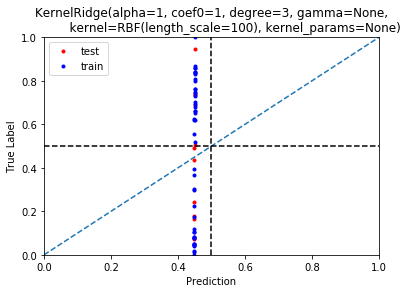

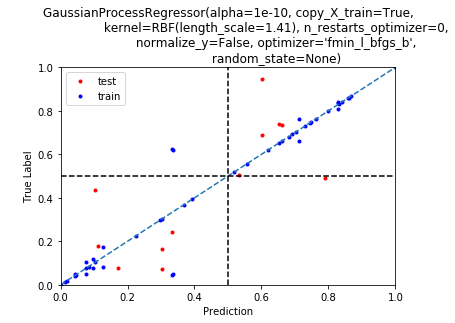

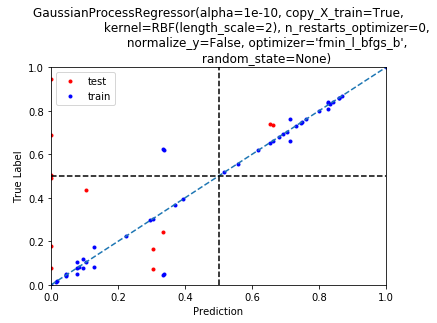

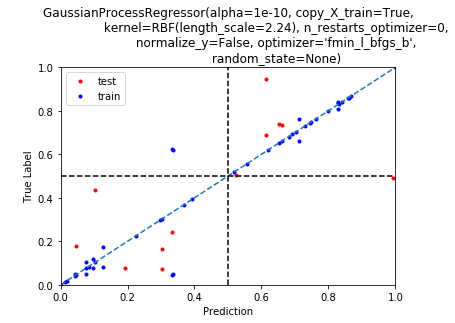

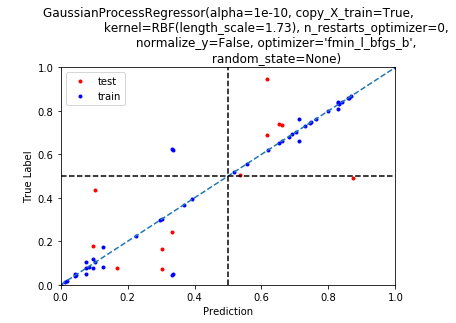

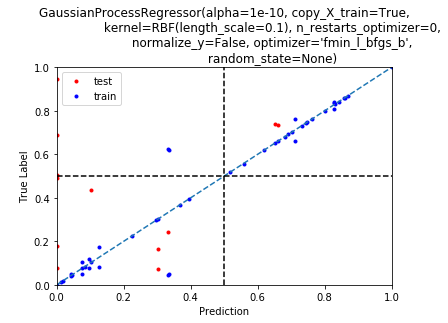

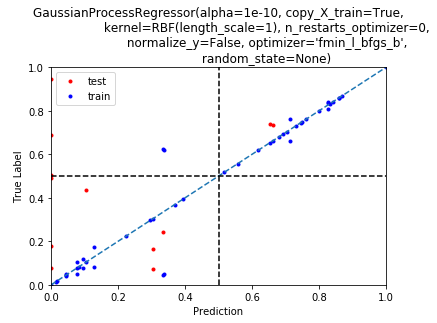

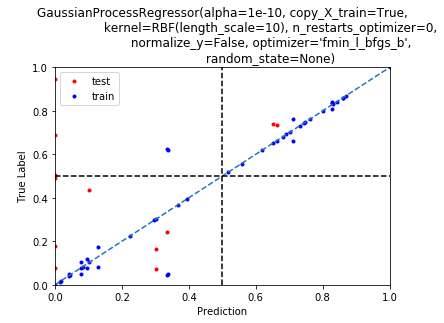

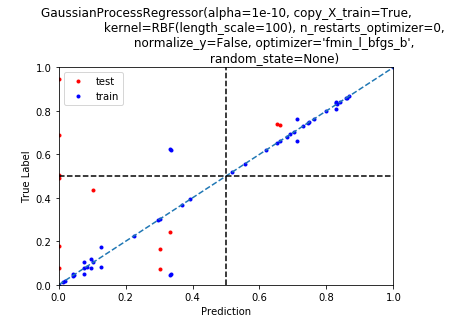

In [11]:
def run_regression(model, kernel, embedding, l):
    reg = Regression(model(kernel = kernel), data, embedding)
    reg.train()
    train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag, plot_flag = plot_flag)
    key = regression_name[model] + '_RBF(' +  str(round(l,2)) + ')'
    train_scores[key] = train_score
    test_scores[key] = test_score
    print()

for model in [KernelRidge, GaussianProcessRegressor]:
    for l in len_scale:
        run_regression(model, RBF(l), 'onehot', l)    

Text(0.5, 1.0, 'Test Scores')

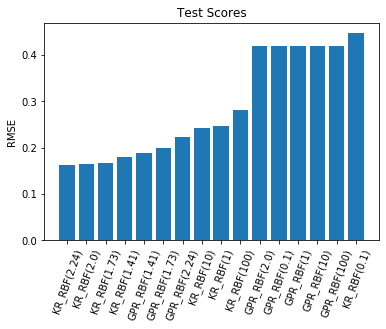

In [12]:
sorted_test_scores = sorted(test_scores.items(), key=lambda kv: kv[1])

import collections

sorted_test_scores = collections.OrderedDict(sorted_test_scores)

plt.bar(range(len(sorted_test_scores)), list(sorted_test_scores.values()), align='center')
plt.xticks(range(len(sorted_test_scores)), list(sorted_test_scores.keys()), rotation = 70)
plt.ylabel('RMSE')
plt.title('Test Scores')

Looking at the scores on the validation set, we get a better model for length scale in the range between 1.4 and 2.3. We'll use length_scale = 1.4 as the following bandits algorithms.